###

In [94]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import math
import itertools
from random import choice

from datetime import datetime
from datetime import timedelta

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import pmdarima
from pmdarima.arima.utils import ndiffs

In [2]:
trading_portfolio = pd.ExcelFile('trading_portfolio.xlsx')
trading_portfolio #load the Excel file with data from all the sheets

In [3]:
trading_portfolio.sheet_names # output of this is a list of all the sheets within the Excel file
# therefore, you can loop through the sheet names and load them into dataframes individually

['Russia - Sberbank Rossii PAO (S',
 'Turkey - Koc Holding AS (KCHOL)',
 'Egypt - Medinet Nasr Housing (M',
 'Brazil - Minerva SABrazil (BEEF',
 'Argentina - Pampa Energia SA (P',
 'Colombia - Cementos Argos SA (C',
 'South Africa - Impala Platinum ',
 'South Korea - Dongkuk Steel Mil']

## Read one company stock info into a dataframe

In [4]:
# read one of the excel file sheets into a dataframe
df = pd.read_excel('trading_portfolio.xlsx', sheet_name = trading_portfolio.sheet_names[1])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      316 non-null    object 
 1   Price     316 non-null    object 
 2   Open      316 non-null    object 
 3   High      316 non-null    object 
 4   Low       316 non-null    object 
 5   Vol.      315 non-null    object 
 6   Change %  315 non-null    float64
dtypes: float64(1), object(6)
memory usage: 17.4+ KB


## Data cleaning

In [6]:
df = df[:-1].copy() #drop the last row by slicing and create a deep copy so that subsequent changes will not throw the warning
# 'A value is trying to be set on a copy of a slice from a DataFrame...'

In [7]:
# convert date from string object to datetime format

df['Date'] = pd.to_datetime(df['Date'])

In [8]:
# several of the columns are string objects. Convert to numeric
df[['Price','Open', 'High', 'Low', 'Change %']] = df[['Price','Open', 'High', 'Low', 'Change %']].apply(pd.to_numeric)

In [9]:
df['Vol.'] = df['Vol.'].apply(lambda x: x[:-1]).astype('float32') # for the volume column remove M (for millions)
# and then convert to float32 and normalize to the maximum

In [10]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31,19.41,19.42,19.63,19.27,13.140000,-0.0046
1,2021-03-30,19.50,19.12,19.81,19.03,21.049999,0.0209
2,2021-03-29,19.10,19.24,19.67,19.10,16.559999,-0.0078
3,2021-03-26,19.25,20.28,20.36,19.10,21.350000,-0.0385
4,2021-03-25,20.02,20.50,20.86,20.02,15.930000,-0.0148


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      315 non-null    datetime64[ns]
 1   Price     315 non-null    float64       
 2   Open      315 non-null    float64       
 3   High      315 non-null    float64       
 4   Low       315 non-null    float64       
 5   Vol.      315 non-null    float32       
 6   Change %  315 non-null    float64       
dtypes: datetime64[ns](1), float32(1), float64(5)
memory usage: 16.1 KB


## Plot the stock price vs the date in 2020 and 2021

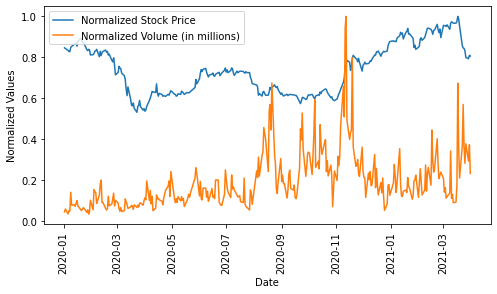

In [12]:
# plot the 'Price' and 'Vol.' columns, both normalized to their maximum values (so as to observe if there are trends between
# the stock price and the volume)
plt.figure(figsize = (8,4))
sns.lineplot(x = df['Date'], y = df['Price']/df['Price'].max())
sns.lineplot(x = df['Date'], y = df['Vol.']/df['Vol.'].max())
plt.xticks(rotation= 90)
plt.ylabel('Normalized Values')
plt.legend(loc = 'upper left', labels= ['Normalized Stock Price','Normalized Volume (in millions)'])
plt.show()
#there is no clear trend. Some increases in the price (between 2020-11 and 2021-01) is preceded by large transaction volumes
# while others (e.g. between 2020-4 and 2020-6) is not. 
# So transaction volumnes may not be a good indicator of a subsequent increase in stock prices

# 1) Predicting daily stock prices

## Create training and testing data from closing stock prices
## All prices from 2020 - > Training
## All prices from 2021 -> testing

In [13]:
# for the dataset, we will use all Q1 - Q4 data from 2020 for training and Q1 data from 2021 as testing
# select 2021 Q1 data as follows
# select just the Price column and convert values to a list form
X_test = list(df[pd.DatetimeIndex(df['Date']).year == 2021]['Price'].values)
X_test[:20]#truncated display

[19.41,
 19.5,
 19.1,
 19.25,
 20.02,
 20.32,
 20.36,
 20.66,
 22.94,
 23.78,
 24.08,
 23.48,
 23.28,
 23.28,
 23.36,
 23.44,
 23.26,
 22.56,
 23.08,
 22.9]

In [14]:
# likewise, selecte all data from 2020 for training the model
X_train = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Price'].values)
X_train[:20] #truncated display

[21.12,
 20.94,
 20.62,
 20.0,
 19.9,
 19.97,
 19.84,
 19.68,
 19.39,
 20.0,
 19.89,
 19.91,
 19.52,
 19.54,
 19.05,
 18.8,
 18.85,
 18.62,
 18.53,
 18.49]

In [15]:
len(X_train), len(X_test)

(252, 63)

In [189]:
errors_dict = {'Model':[], 'MAE':[], 'MSE':[], 'MAPE':[]} #create a dictionary to store the errors estimated from each Time Series Model tested

# (1) Try a simple Moving Average (MA) model

In [87]:
# try moving average terms randing from 1 to 6
# following creates a dictionary with 
num_test_obser = len(X_test)
predictions = {}

for lag in range (1,7):
    X_train = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Price'].values) # reset the X_train since it changes with each
                                                                                  # inner loop below
    lst_temp = []
    #('model_predictions_MA_'+str(lag)) = []# create a customized list for each MA lag
    
    for i in range(num_test_obser):
        
        
        model_MA = ARIMA(X_train, order=(0,0,lag)) # use an ARIMA model where the AR and differencing terms are set = 0
        model_MA_fit = model_MA.fit()
        output = model_MA_fit.forecast()
        lst_temp.append(output[0])
        X_train.append(X_test[i])
        
    predictions['model_predictions_MA_'+str(lag)]= lst_temp #append list of predictions to predictions dictionary


C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\tsa\statespace

In [190]:
def calc_errors (preds, truths):
    MAE = mean_absolute_error(preds, truths)
    MSE = mean_squared_error(preds, truths)
    MAPE = mean_absolute_percentage_error(preds, truths)
    return MAE, MSE, MAPE

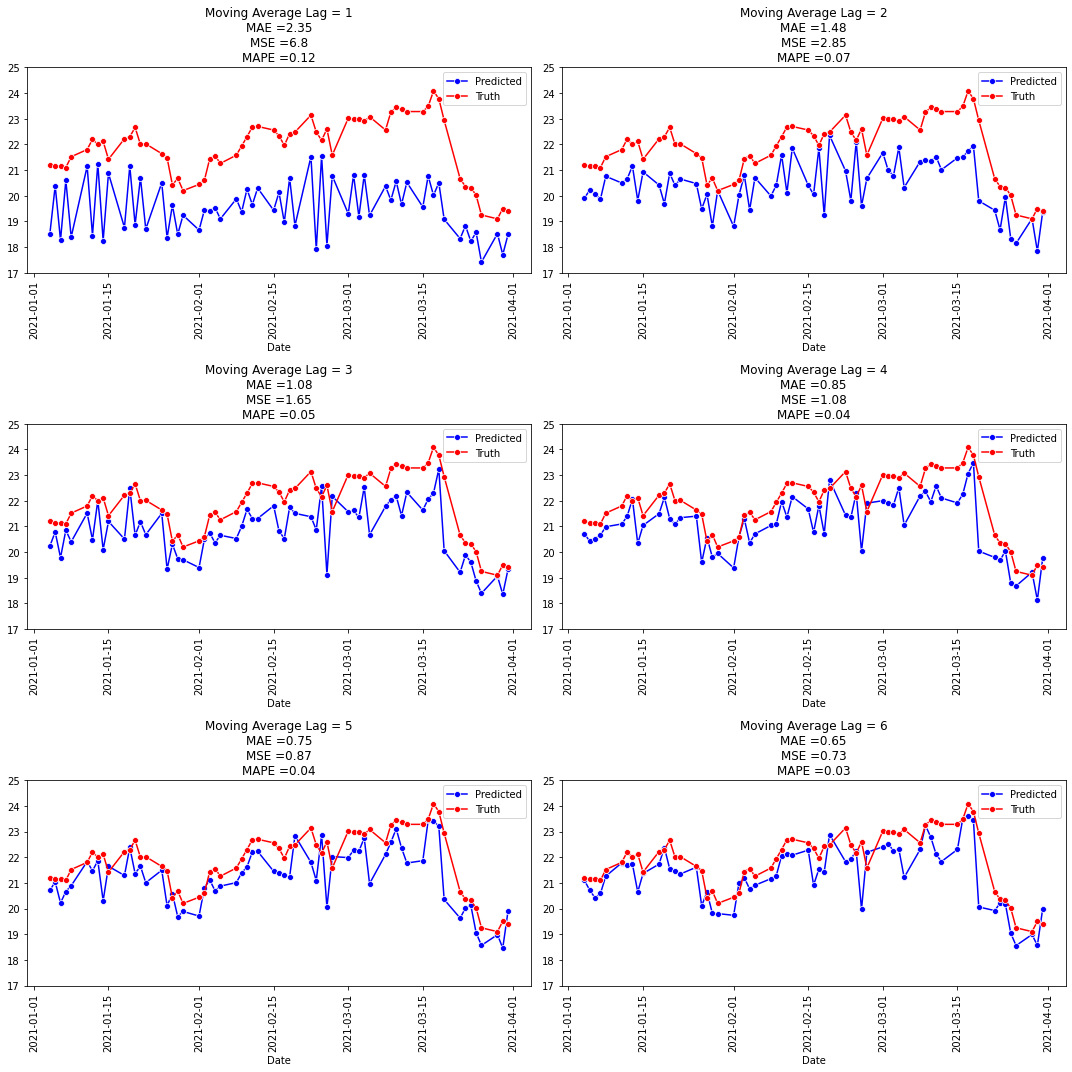

In [192]:
fig, axes = plt.subplots(3, 2, figsize = (15,15))

for ind in range(1,7):
    axes = plt.subplot(3,2,ind)
    date_range = df[pd.DatetimeIndex(df['Date']).year == 2021]['Date']
    #use prediction values from each of the MA lags from the predictions dictionary
    preds = predictions['model_predictions_MA_'+str(ind)] #extract the corresponding predictions data from the dictionary
    sns.lineplot(x=date_range, y=preds, color = 'blue', marker = 'o', label = 'Predicted', ax=axes)
    sns.lineplot(x=date_range, y=X_test, color = 'red', marker = 'o', label = 'Truth', ax=axes)
    plt.xticks(rotation = 90)
    plt.ylim(17,25)
    MAE, MSE, MAPE = calc_errors(preds, X_test)
    plt.title('Moving Average Lag = '+str(ind)+'\n'+'MAE ='+str(round(MAE,2))+
             '\n'+'MSE ='+str(round(MSE,2))+'\n'+'MAPE ='+str(round(MAPE,2)))
    
plt.tight_layout()

Of the lags tested, the best lag for predicting with the moving average is 6. It is clear that the predictions are very good with a simple moving average model

In [193]:
# store the error metrics in the dictionary
errors_dict['Model'].append('Moving average lag = 6')
errors_dict['MAE'].append(MAE)
errors_dict['MSE'].append(MSE)
errors_dict['MAPE'].append(MAPE)

In [194]:
errors_dict

{'Model': ['Moving average lag = 6'],
 'MAE': [0.6465077044440648],
 'MSE': [0.732034610137669],
 'MAPE': [0.030835971066020162]}

## (2) Try a Simple Exponential Moving Average (SES) model

In [150]:
X_train = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Price'].values) # reset X_train

model_ses_predictions = []
num_test_obser = len(X_test)


for i in range (num_test_obser):
    model_ses = SimpleExpSmoothing(X_train)
    model_ses_fit = model_ses.fit()
    
    output_ses = model_ses_fit.forecast()
    model_ses_predictions.append(output_ses[0])
    
    X_train.append(X_test[i])   

Text(0.5, 1.0, 'Simple Exponential Smoothing (SES)')

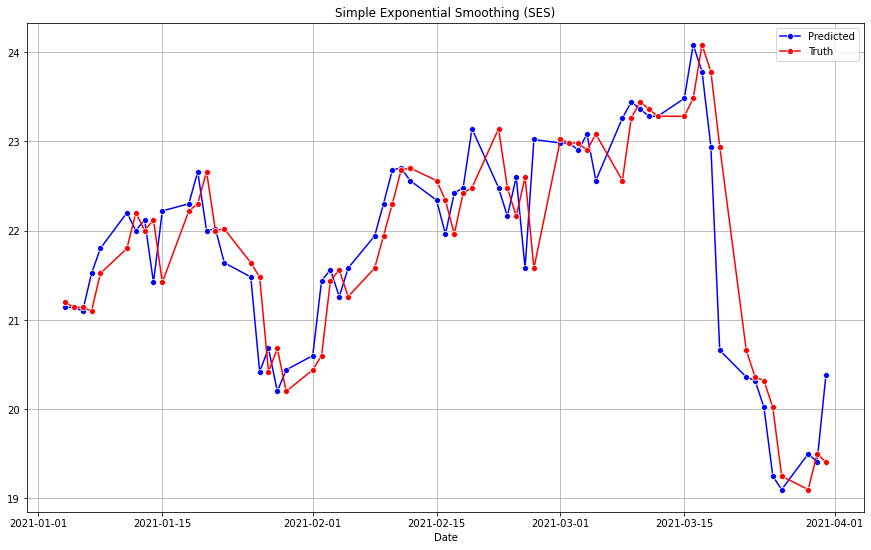

In [151]:
# plot the predicted and truth values for 2021

plt.figure(figsize = (15, 9))
plt.grid(True)

date_range = df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'] # dates of the test data used for graph's X_axis
sns.lineplot(x=date_range, y=model_ses_predictions, color = 'blue', marker = 'o', label = 'Predicted')
sns.lineplot(x=date_range, y=X_test, color = 'red', marker = 'o', label = 'Truth')
plt.title('Simple Exponential Smoothing (SES)')

In [195]:
#Estimate the errors using the calc_errors function. The SES model is better than the Moving Average model with a lag of 6

MAE,MSE,MAPE = calc_errors (model_ses_predictions, X_test)
print('Mean Absolute Error :', MAE)
print('Mean Squared Error :', MSE)
print('Mean Absolute Percentage Error :', MAPE)

Mean Absolute Error : 0.38857142849100795
Mean Squared Error : 0.3019428570270525
Mean Absolute Percentage Error : 0.017928811041039345


In [196]:
# store the error metrics in the dictionary
errors_dict['Model'].append('Simple Exponential Smoothing (SES)')
errors_dict['MAE'].append(MAE)
errors_dict['MSE'].append(MSE)
errors_dict['MAPE'].append(MAPE)

## (3) Try ARIMA model using optimal parameters for p,d and q

### Do a grid-search-like method to identify the optimal values p, d, q values for an ARIMA model

In [99]:
# define the ranges of values p and q can take on from 0 to 4 (range 0 to but not including 5)
p=q=range(0,5)
# define the values of d to be 1 or 2 (first or second order differencing only)
d=(1,2)

#create a list of all combinations of p,d and q values (cartersian products)
pdq = list(itertools.product(p,d,q))
pdq[:10] #first 10 of the pdq value combinations

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4)]

In [100]:
len(pdq)

50

Following code block is similar to doing a grid-search to identify optimal parameters.

For each pdq combination, determine AIC and BIC values while at the same time doing exception handling and warning detection.
If an error is generated with a particular pdq combination, continue to the next value
If a warning is generated (e.g. Convergence warning), the AIC and BIC values are flagged to be removed later.
For each pdq combination, loop through the length of X_test and append each X_test value to X_train, in a similar manner as would be done when using the model to predict next day's share price

The code block below is marked down after the first run since it took a long time to run.


pdq_aic_bic = {'pdq':[], 'aic': [], 'bic': [], 'warning': []}

num_test_obser = len(X_test)

for params in pdq:
    
    for i in range(num_test_obser):
    
        # some of the p,d,q parameters may generate errors, therefor use exception handling to avoid them while running the
        # pdq values
        try:

            model_grid_search = ARIMA(X_train, order = params)

            #some p,d,q values may generate warnings, use catch_warnings to located which of the p,d,q value sets
            # generated the warnings
            with warnings.catch_warnings (record=True) as caught_warning:
                warnings.simplefilter("always")
                #fit the model
                model_gs_fit =  model_grid_search.fit()

                if len(caught_warning)>0: #if caught_warning list length is not zero, append the number of warnings to the
                    #pdq_aic_bic dictionary
                    pdq_aic_bic['warning'].append(len(caught_warning))

                else: # if the waught_warning is zero, append zero to the dictionary
                    pdq_aic_bic['warning'].append(0)

            # append the params, aic and bic values to the dicstionary
            pdq_aic_bic['pdq'].append(params)
            pdq_aic_bic['aic'].append(model_gs_fit.aic)
            pdq_aic_bic['bic'].append(model_gs_fit.bic)
            
            # add each value of X_test to X_train, in a similar manner as when predictions are carried out later 
            X_train.append(X_test[i])

        except:
            # if the try code generates an error, add each value of X_test to X_train, in a similar manner 
            # as when predictions are carried out later and move to the next X_test value (share price)m
            X_train.append(X_test[i])
            continue
        

In [101]:
# read the csv file with the AIC, BIC values
aic_bic_df = pd.read_csv('pdq_aic_bic.csv') # read the csv file
aic_bic_df['aic_bic_avg'] = (aic_bic_df['aic']+aic_bic_df['bic'])/2

#### If the above code block used to do the grid-search is run, following lines of code creates a dataframe
#### and saves it to a csv file

aic_bic_df = pd.DataFrame(pdq_aic_bic)   
aic_bic_df['aic_bic_avg'] = (pd.DataFrame(pdq_aic_bic)['aic']+pd.DataFrame(pdq_aic_bic)['bic'])/2

aic_bic_df.to_csv('pdq_aic_bic.csv') #save to csv file

In [102]:
aic_bic_df.shape

(3150, 6)

In [103]:
aic_bic_df.head()

,Unnamed: 0,pdq,aic,bic,warning,aic_bic_avg
0,0,"(0, 1, 0)",367.941237,371.690630,0,369.815934
1,1,"(0, 1, 0)",384.773153,388.525726,0,386.649440
2,2,"(0, 1, 0)",385.027890,388.783632,0,386.905761
3,3,"(0, 1, 0)",386.053116,389.812018,0,387.932567
4,4,"(0, 1, 0)",386.377824,390.139875,0,388.258850


In [104]:
# drop the Unnamed: 0 column which is identical to the df index
aic_bic_df = aic_bic_df.drop(columns=['Unnamed: 0'], axis=1)

In [105]:
#create a new df where warning ==0 (i.e. exclude all pdq combinations that generated any warning)
pdq_filtered = aic_bic_df[aic_bic_df['warning']==0]
pdq_filtered.shape

(2077, 5)

In [108]:
# the minimum aic and bic average is with p,d,q values of 0,1,0
# a simple differencing model that do not use AR and/or MA terms may not have strong perdictive capability for other datasets
# so we will avoid using 0,1,0 in the ARIMA model

pdq_filtered[pdq_filtered['aic_bic_avg'] == pdq_filtered['aic_bic_avg'].min()]

,pdq,aic,bic,warning,aic_bic_avg
0,"(0, 1, 0)",367.941237,371.69063,0,369.815934


In [107]:
# the following line of code extracts the rows from the dataframe where the average of aic and bic values are 
# between 300 and 700 and corresponding p,d,q values are  
# all these values were associated with p,d,q of 0 , 1, 1 or 0, 1, 2

pdq_filtered[(pdq_filtered['pdq']!= '(0, 1, 0)') & (pdq_filtered['aic_bic_avg']>300) & (pdq_filtered['aic_bic_avg']<700)]

,pdq,aic,bic,warning,aic_bic_avg
63,"(0, 1, 1)",490.512745,498.377236,0,494.444990
64,"(0, 1, 1)",505.619947,513.489736,0,509.554841
65,"(0, 1, 1)",506.005376,513.880449,0,509.942913
66,"(0, 1, 1)",507.061584,514.941926,0,511.001755
67,"(0, 1, 1)",507.493200,515.378799,0,511.436000
...,...,...,...,...,...
163,"(0, 1, 2)",689.391767,701.894317,0,695.643042
164,"(0, 1, 2)",690.239529,702.748361,0,696.493945
165,"(0, 1, 2)",690.996633,703.511735,0,697.254184
166,"(0, 1, 2)",691.882347,704.403705,0,698.143026


Since a simple differencing process alone should not alone be responsible for an ARIMA model where the AR and MA terms are zero. In the above dataframe, we can try p=0, d=1 and q=1 or q=2 where at least the MA term can be incorporated without generating warnings. However, these pdq values did generate higher AIC and BIC values.

In [200]:
# use the above identified p, d and q values (0,1,1) or (0,1,2) to train the ARIMA model

model_predictions = []
num_test_obser = len(X_test)

for i in range(num_test_obser):
    model = ARIMA(X_train, order = (0, 1, 2)) # where p = 0 which is the number of lag observations, 
                                              #  d = 1 which is the number of times the raw observations are differenced to make them stationary
                                              # q = 0 which is the size of the moving average window
    model_fit =  model.fit()
    output = model_fit.forecast()
    
    model_predictions.append (output[0]) # append the predicted value to the model2_predictions list
    
    true_test_value = X_test[i] # the corresponding test value of the X_test list
    X_train.append(true_test_value)

C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [166]:
model_predictions[:10] # compare predictions to actual share prices (next line of code)

[21.201733094218188,
 19.361356784599696,
 19.503086276122325,
 19.090990618499106,
 19.25339582562905,
 20.037865110135446,
 20.327406195435103,
 20.36086616827296,
 20.667990671268843,
 23.0230335162922]

In [111]:
X_test[:10]

[19.41, 19.5, 19.1, 19.25, 20.02, 20.32, 20.36, 20.66, 22.94, 23.78]

<AxesSubplot:xlabel='Date'>

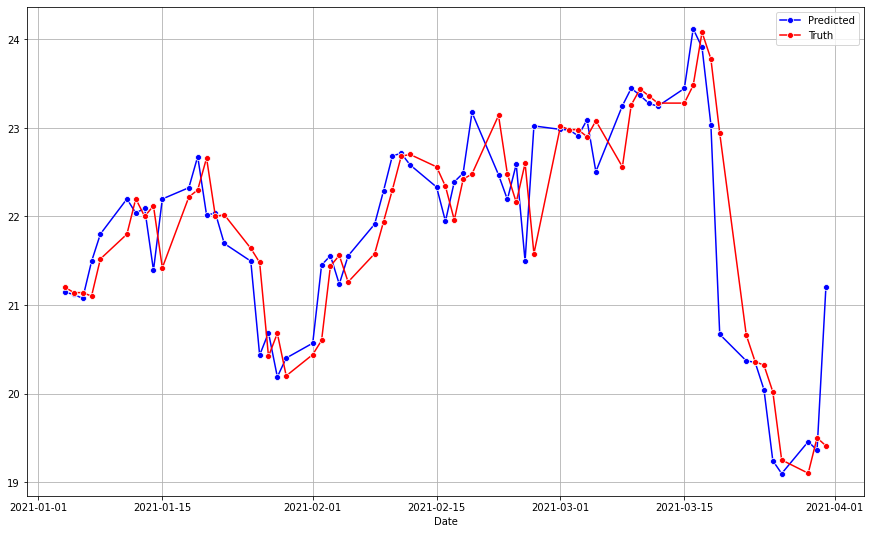

In [201]:
# plot the predicted and truth values for 2021

plt.figure(figsize = (15, 9))
plt.grid(True)

date_range = df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'] # dates of the test data used for graph's X_axis
sns.lineplot(x=date_range, y=model_predictions, color = 'blue', marker = 'o', label = 'Predicted')
sns.lineplot(x=date_range, y=X_test, color = 'red', marker = 'o', label = 'Truth')
#there is an offset of one day between Predicted and Truth values

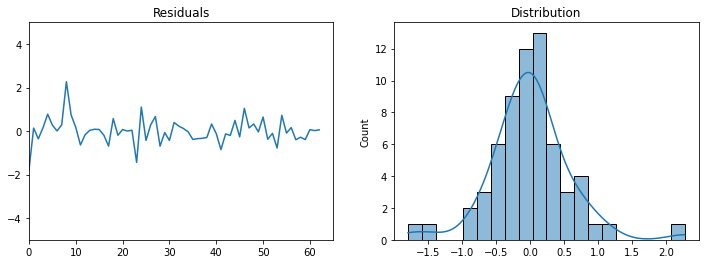

In [202]:
residuals = np.array(X_test) - np.array(model_predictions)
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.lineplot(x=range(len(residuals)), y = residuals, ax=axes[0])
axes[0].set_ylim([-5, 5])
axes[0].set_xlim([0, 65])
axes[0].set_title("Residuals")
sns.histplot(x=residuals, bins=20, kde=True, ax=axes[1])
axes[1].set_title("Distribution")
plt.show()
# the residual errors have a mean of 0 and variance that is normally distributed around mean of 0

In [203]:
# calculate the error metrics for model_fit using calc_errors function from above
MAE,MSE,MAPE = calc_errors (model_predictions, X_test)
print('Mean Absolute Error :', MAE)
print('Mean Squared Error :', MSE)
print('Mean Absolute Percentage Error :', MAPE)

Mean Absolute Error : 0.3972469180914305
Mean Squared Error : 0.3360832191105607
Mean Absolute Percentage Error : 0.01831977372315354


In [204]:
# store the error metrics in the dictionary
errors_dict['Model'].append('ARIMA (0,1,2)')
errors_dict['MAE'].append(MAE)
errors_dict['MSE'].append(MSE)
errors_dict['MAPE'].append(MAPE)

In [205]:
errors_dict

{'Model': ['Moving average lag = 6',
  'Simple Exponential Smoothing (SES)',
  'ARIMA (0,1,1)',
  'ARIMA (0,1,2)'],
 'MAE': [0.6465077044440648,
  0.38857142849100795,
  0.40322506461907737,
  0.3972469180914305],
 'MSE': [0.732034610137669,
  0.3019428570270525,
  0.3398752801781589,
  0.3360832191105607],
 'MAPE': [0.030835971066020162,
  0.017928811041039345,
  0.018595567952253398,
  0.01831977372315354]}

As with Moving Average and SES models, the ARIMA model showed relatively decent predictions when the predictions and X_test values are compared graphically. However, 

# (4) Try ARIMAX model - where share volume data as an exogenous factor?

In [137]:
X_train_exog = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Vol.'].values)

In [138]:
X_test_exog = list(df[pd.DatetimeIndex(df['Date']).year == 2021]['Vol.'].values)

In [139]:
len(X_train_exog), len(X_test_exog)

(252, 63)

In [208]:
model_arimax_predictions = []
num_test_obser = len(X_test)

#redefine X_train, X_test, X_train_exog and X_test_exog values each time this code block is run
# (since the X_train and X_train_exog lists increase in length)
X_train = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Price'].values)
X_test = list(df[pd.DatetimeIndex(df['Date']).year == 2021]['Price'].values)
X_train_exog = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Vol.'].values)
X_test_exog = list(df[pd.DatetimeIndex(df['Date']).year == 2021]['Vol.'].values)

for i in range(num_test_obser):
    model_arimax = ARIMA(X_train, order = (0, 1, 2), exog=X_train_exog) # where p = 0 which is the number of lag observations, 
                                              #  d = 1 which is the number of times the raw observations are differenced to make them stationary
                                              # q = 0 which is the size of the moving average window
    model_arimax_fit =  model_arimax.fit()
    output_arimax = model_arimax_fit.forecast(exog=X_test_exog[i])# need to provide the corresponding exogenous value for 
                                                                  #each forecast
    
    model_arimax_predictions.append (output_arimax[0]) # append the predicted value to the model2_predictions list
    
    true_test_value = X_test[i] # the corresponding test value of the X_test list
    true_exog_value = X_test_exog[i]
    X_train.append(true_test_value)
    X_train_exog.append(true_exog_value)

C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [173]:
print(model_arimax_fit.summary()) # the p value for exogenous variable (X1) is greater than 0.5 indicating 
# it has little predictive capability for the share price

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  314
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -182.203
Date:                Sun, 14 Aug 2022   AIC                            370.406
Time:                        12:31:22   BIC                            381.644
Sample:                             0   HQIC                           374.897
                                - 314                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0044      0.003      1.314      0.189      -0.002       0.011
ma.L1          0.0272      0.042      0.642      0.521      -0.056       0.110
sigma2         0.1876      0.010     19.211      0.0

<AxesSubplot:xlabel='Date'>

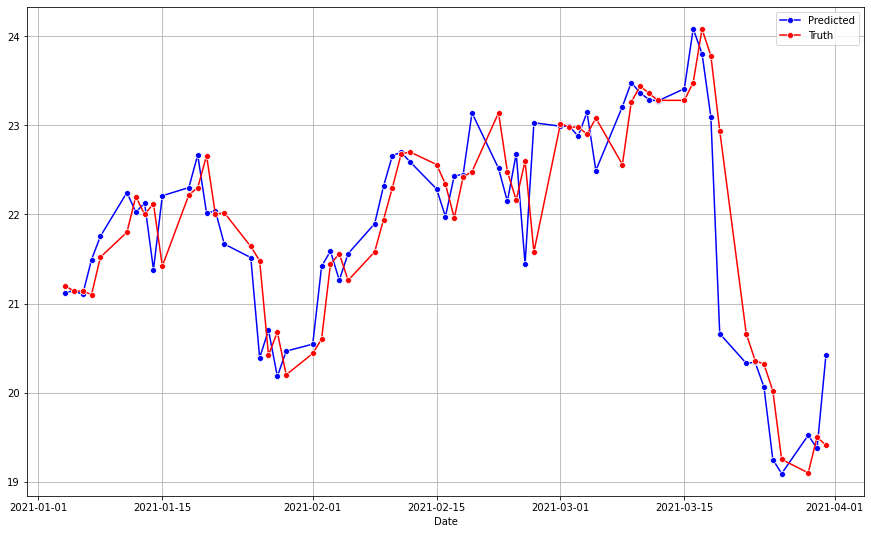

In [209]:
# plot the predicted and truth values for 2021 using exogenous variable (i.e. ARIMAX)

plt.figure(figsize = (15, 9))
plt.grid(True)

date_range = df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'] # dates of the test data used for graph's X_axis
sns.lineplot(x=date_range, y=model_arimax_predictions, color = 'blue', marker = 'o', label = 'Predicted')
sns.lineplot(x=date_range, y=X_test, color = 'red', marker = 'o', label = 'Truth')
#there is an offset of one day between Predicted and Truth values

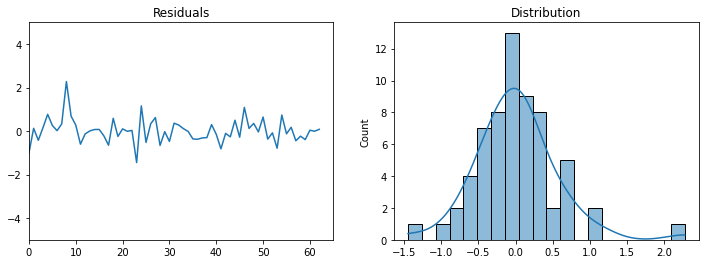

In [210]:
residuals_arimax = np.array(X_test) - np.array(model_arimax_predictions)
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.lineplot(x=range(len(residuals_arimax)), y = residuals_arimax, ax=axes[0])
axes[0].set_ylim([-5, 5])
axes[0].set_xlim([0, 65])
axes[0].set_title("Residuals")
sns.histplot(x=residuals_arimax, bins=20, kde=True, ax=axes[1])
axes[1].set_title("Distribution")
plt.show()
# the residual errors in ARIMAX are pretty similar

In [211]:
MAE,MSE,MAPE = calc_errors (model_arimax_predictions, X_test)
print('Mean Absolute Error :', MAE)
print('Mean Squared Error :', MSE)
print('Mean Absolute Percentage Error :', MAPE)

Mean Absolute Error : 0.3899815245210406
Mean Squared Error : 0.3060953262742347
Mean Absolute Percentage Error : 0.018009548654389352


In [212]:
# calculate the error metrics for model_arimax_fit
# store the error metrics in the dictionary
errors_dict['Model'].append('ARIMAX (0,1,2)')
errors_dict['MAE'].append(MAE)
errors_dict['MSE'].append(MSE)
errors_dict['MAPE'].append(MAPE)

In [213]:
errors_dict

{'Model': ['Moving average lag = 6',
  'Simple Exponential Smoothing (SES)',
  'ARIMA (0,1,1)',
  'ARIMA (0,1,2)',
  'ARIMAX (0,1,1)',
  'ARIMAX (0,1,2)'],
 'MAE': [0.6465077044440648,
  0.38857142849100795,
  0.40322506461907737,
  0.3972469180914305,
  0.388836397441897,
  0.3899815245210406],
 'MSE': [0.732034610137669,
  0.3019428570270525,
  0.3398752801781589,
  0.3360832191105607,
  0.3059398998546154,
  0.3060953262742347],
 'MAPE': [0.030835971066020162,
  0.017928811041039345,
  0.018595567952253398,
  0.01831977372315354,
  0.01795731609349201,
  0.018009548654389352]}

In [217]:
errors_df

,Model,MAE,MSE,MAPE,errors_avg
0,Moving average lag = 6,0.646508,0.732035,0.030836,0.4698
1,Simple Exponential Smoothing (SES),0.388571,0.301943,0.017929,0.2361
2,"ARIMA (0,1,1)",0.403225,0.339875,0.018596,0.2539
3,"ARIMA (0,1,2)",0.397247,0.336083,0.018320,0.2505
4,"ARIMAX (0,1,1)",0.388836,0.305940,0.017957,0.2376
5,"ARIMAX (0,1,2)",0.389982,0.306095,0.018010,0.2380


In [218]:
errors_df = pd.DataFrame(errors_dict)
errors_df['errors_avg'] = round(errors_df[['MAE','MSE', 'MAPE']].mean(axis=1),4)
errors_df.sort_values(by = ['errors_avg'], ascending=True, inplace=True)
errors_df

,Model,MAE,MSE,MAPE,errors_avg
1,Simple Exponential Smoothing (SES),0.388571,0.301943,0.017929,0.2361
4,"ARIMAX (0,1,1)",0.388836,0.305940,0.017957,0.2376
5,"ARIMAX (0,1,2)",0.389982,0.306095,0.018010,0.2380
3,"ARIMA (0,1,2)",0.397247,0.336083,0.018320,0.2505
2,"ARIMA (0,1,1)",0.403225,0.339875,0.018596,0.2539
0,Moving average lag = 6,0.646508,0.732035,0.030836,0.4698


Of these models tested, the Simple Exp Smoothing (SES) model is very marginally better than the ARIMAX models (where p,d,q are either (0,1,1) or (0,1,2)) which in turn is very marginally better than the ARIMA models(p,d,q are either (0,1,1) or (0,1,2)). The Moving Average model with a lag of 6 provides the least accurate predictions.

# (5) How effective is random trading in helping to make money?
### Random trading can then be compared to how well an ARIMA model will perform

In [219]:
#specify starting and ending dates (this is the data available from 2021 that can be used in simulations)
starting_date = df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'].min()
ending_date = df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'].max()

In [220]:
#define functions for buying or selling shares. It is assumed that trading commissions are not charged for buying or selling

# for buying shares
def buy_shares(capital_available, share_price): # assume no commissions for buying
    """ Input: capital available to buy shares at the specified share price
        Output: the number of whole shares bought and the balance available after the purchase
    """
    num_shares_bought = int(capital_available/share_price)
    money_left = capital_available - (num_shares_bought* share_price)
    return num_shares_bought, round(money_left,2)


#for selling shares
def sell_shares (num_shares, share_price): # assume no commisions for selling
    """ Input:  tnumber of shares to be sold at the specified share price
        Output: the total proceeds from the sale
    """
    proceeds = num_shares * share_price
    return round(proceeds,2)

In [221]:
# following block of code loops through all the dates between starting and ending dates for each run of random trades.

sh = ['sell', 'hold']
bh = ['buy', 'hold']

def run_simulation(num_cycles, starting_capital):
    
    starting_capital = starting_capital
    
    #specify a dictionary to store the total number of cycles, ending capital of after each cycle and loss/gain after each cycle
    end_capital = {'num':0,
                   'tot_capital':[],
                   'loss_gain':[]}
    
    for cycle in range (num_cycles):
        
    
        for i in (df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'][::-1]):
            if i == starting_date:
                choose_trade = 'buy'
                num_shares_bought, money_left = buy_shares(starting_capital, df[df['Date'] == i]['Price'].iloc[0])
                #print('First', choose_trade, num_shares_bought, money_left)

            elif i == ending_date:

                if choose_trade == 'buy': # if the previous to last date was a 'buy', then sell the shares
                    proceeds = sell_shares(num_shares_bought, df[df['Date'] == i]['Price'].iloc[0])
                    ending_capital = round(proceeds+money_left, 2)
                    loss_or_gain = round(ending_capital - starting_capital, 2)
                    #print('Last a', ending_capital, loss_or_gain)
                    
                    end_capital['num']+=1
                    end_capital['tot_capital'].append(ending_capital)
                    end_capital['loss_gain'].append(loss_or_gain)
                    
                elif choose_trade == 'sell': # if previous to last was a 'sell', then ending capital is the money_left
                    ending_capital = money_left
                    loss_or_gain = round(ending_capital - starting_capital, 2)
                    #print('Last b', ending_capital, loss_or_gain)
                    
                    end_capital['num']+=1
                    end_capital['tot_capital'].append(ending_capital)
                    end_capital['loss_gain'].append(loss_or_gain)

                else: # if previous to last was a 'hold', then sell
                    ending_capital = sell_shares (num_shares_bought,df[df['Date'] == i]['Price'].iloc[0])
                    loss_or_gain = round(ending_capital - starting_capital, 2)
                    #print('Last c', ending_capital, loss_or_gain)
                    
                    end_capital['num']+=1
                    end_capital['tot_capital'].append(ending_capital)
                    end_capital['loss_gain'].append(loss_or_gain)

            elif choose_trade == 'buy':
                choose_trade = choice(sh) 
                if choose_trade == 'sell':
                    money_left+= sell_shares(num_shares_bought, df[df['Date'] == i]['Price'].iloc[0])
                    #print ('3a', choose_trade, round(money_left,2))        
                else:
                    #print('3b', choose_trade, round(money_left,2))
                    continue

            elif choose_trade == 'sell':
                choose_trade = 'buy'
                num_shares_bought, money_left = buy_shares (money_left, df[df['Date'] == i]['Price'].iloc[0])
                #print ('4', choose_trade, num_shares_bought, round(money_left,2))

            else:
                choose_trade =  choice (sh)
                if choose_trade == 'sell':
                    money_left += sell_shares(num_shares_bought, df[df['Date'] == i]['Price'].iloc[0])
                    #print('5a', choose_trade, round(money_left,2))
                else:
                    #print('5b', choose_trade, round(money_left,2))
                    continue
                    
    return end_capital     

In [222]:
# run the above simulation many times (say 1000) with a starting capital of $1000 (or the currency of the share price)

dict_1 = run_simulation(2000, 1000) #run 2000- simulations with $1000 in each simulation

ending_capital = round(np.array(dict_1['tot_capital']).mean(), 2)
ending_loss_gain = round(np.array(dict_1['loss_gain']).mean(), 2)

ending_capital, ending_loss_gain

(942.21, -57.79)

The average capital at the end of each run is about $60 lower than starting. So on average, you are losing money when you randomly select trading (buy, sell or hold).

Text(0.5, 1.0, 'Random Buy, Sell or Hold')

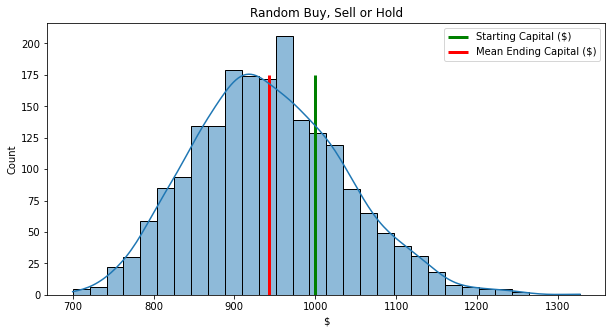

In [224]:
# plot the distribution of the capital left at the end after running the random trade simulation (e.g.1000 times)
plt.figure(figsize=(10,5))
sns.histplot(data = dict_1, x=dict_1['tot_capital'], bins = 30, kde=True)
plt.vlines(x=1000, ymin = 0, ymax=175, color='g', linewidth=3, label = 'Starting Capital ($)')
plt.vlines(x=np.array(dict_1['tot_capital']).mean(), ymin = 0, ymax=175, color='r', linewidth=3, label = 'Mean Ending Capital ($)')
plt.legend()
plt.xlabel('$')
plt.title('Random Buy, Sell or Hold')

# (6) Make educated guesses on trade position based on forecast share price - Bollinger Bands method 

If the forecast share price exceeds the trailing mean (of 20 days) plus 2 times Standard Deviation (which is normal for decisions based on Bollinger bands), it means the stock is likely over priced and a SELL decision is made. If the forecast share price is less than trailing mean minus 2 times the standard deviation, then the stock is likely under priced and a BUY decision is made. If forecast share price is between mean plus 2 * std and  mean - 2 * std, then a HOLD decision is made.

## Create a function to predict share prices, make trading decisions based on Bollinger Bands and calculate gains/losses

The function assumes that trading commissions = 0 (i.e. free to trade)

In [225]:
X_train = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Price'].values)
X_test = list(df[pd.DatetimeIndex(df['Date']).year == 2021]['Price'].values)

In [226]:
len(X_train), len(X_test)

(252, 63)

In [258]:
# specify X_train, X_test as well as X_train_exog and X_test_exog for the exogenous variable used ('vol.' column).

X_train = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Price'].values)
X_test = list(df[pd.DatetimeIndex(df['Date']).year == 2021]['Price'].values)
X_train_exog = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Vol.'].values)
X_test_exog = list(df[pd.DatetimeIndex(df['Date']).year == 2021]['Vol.'].values)

len(X_train), len(X_train_exog)

(252, 252)

In [259]:
# function to run various time series models with different pdq values (if applicable).

def smart_invest (model, pdq = (0,0,0), sigma = 2, starting_capital = 1000):
    
    """
    Inputs - model of choice - 'ARIMA', 'ARIMAX', 'SES' or 'MA'(Moving Average)
             pdq = p, d, q values as a tuple
             height of the Bollinger Bands is defined by trailing mean+/- sigma* trailing std dev
             starting_capital = the money that is used to buy shares on the first day of trading
             
    Outputs - Money at the end of the trading period
              realized gain or loss
    """
    
    X_train = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Price'].values)
    X_test = list(df[pd.DatetimeIndex(df['Date']).year == 2021]['Price'].values)
    X_train_exog = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Vol.'].values)
    X_test_exog = list(df[pd.DatetimeIndex(df['Date']).year == 2021]['Vol.'].values)

    num_test_obser = len(X_test)
    
    position = 0
    num_shares_bought = 0
    
    for i in range(num_test_obser):
        
        if model == 'ARIMA':
            model_invest = ARIMA(X_train, order = pdq)
        elif model == 'ARIMAX':
            model_invest = ARIMA(X_train, order = pdq, exog=X_train_exog)
        else:
            model_invest = SimpleExpSmoothing(X_train)
            
            
        model_invest_fit =  model_invest.fit()
        
        if model == 'ARIMAX':
            output_invest = model_invest_fit.forecast(exog=X_test_exog[i])
        else:
            output_invest = model_invest_fit.forecast()
         

        trailing_avg = np.array(X_train_2[-20:]).mean()
        trailing_std = np.array(X_train_2[-20:]).std()*sigma

        #print('round :', i)
        if i == 0:

            if output_invest[0] <= (trailing_avg - trailing_std): # if predicted price is less than the threhold std dev
                #then BUY the shares with the starting capital
                num_shares_bought, money_left = buy_shares(starting_capital, X_train[-1]) 
                position = 1 # set position to 1 indicating owning shares
                #print('1a', output_arima1[0], (trailing_avg - trailing_std), num_shares_bought, money_left)

            elif output_invest[0] >= (trailing_avg + trailing_std):# if predicted price is greater than the threhold std dev
                #but there is nothing to sell, so HOLD
                money_left = starting_capital 
                #print('1b', output_arima1[0], (trailing_avg - trailing_std), num_shares_bought, money_left)

            else: money_left = starting_capital

        elif output_invest[0] <= (trailing_avg - trailing_std) and position ==0: #if predicted price is less than the threhold std dev
            # and no shares are owned, BUY shares
            #print(money_left)
            num_shares_bought, money_left = buy_shares(money_left, X_train[-1])
            position = 1
            #print('2', output_arima1[0], (trailing_avg - trailing_std), num_shares_bought, money_left)

        elif output_invest[0] <= (trailing_avg - trailing_std) and position ==1: #if predicted price is less than the threhold std dev
            # and you already own shares, HOLD shares
            pass
            #print(money_left)
            #print('3', output_arima1[0], (trailing_avg - trailing_std), num_shares_bought, money_left)


        elif output_invest[0] >= (trailing_avg + trailing_std) and position ==0: #if predicted price is greater than the threhold std dev
            # and no shares are owned, then HOLD cash
            #print(money_left)
            num_shares_bought, money_left = buy_shares(money_left, X_train[-1])
            position = 1
            #print('4', output_arima1[0], (trailing_avg - trailing_std), num_shares_bought, money_left)


        elif output_invest[0] >= (trailing_avg + trailing_std) and position ==1: #if predicted price is less than the threhold std dev
            # and you already own shares, SELL shares
            #print(money_left)
            money_left+= sell_shares(num_shares_bought, X_train[-1])
            position = 0
            #print('5', output_arima1[0], (trailing_avg - trailing_std), num_shares_bought, money_left)

        X_train.append(X_test[i])#append X_test[i] to X_train
        X_train_exog.append(X_test_exog[i])#append X_test_exog[i] to X_train

    # at the end of the period, if shares are owned, sell and calculate loss/gain
    if position == 1:
        money_left+= sell_shares(num_shares_bought, X_train[-1])
        loss_or_gain = round(money_left - starting_capital, 2)
        #print('capital at end :', money_left)
        #print('Loss/Gain :', loss_or_gain)
        return money_left, loss_or_gain

    # if shares are not owned, just calculate loss/gain
    else:
        loss_or_gain = round(money_left - starting_capital, 2)
        #print('capital at end :', money_left)
        #print('Loss/Gain :', loss_or_gain)
        return money_left, loss_or_gain

In [273]:
# single run of the smart_invest function using an ARIMA model
money_left, loss_or_gain = smart_invest ('ARIMA', pdq = (0,1,1), sigma = 2, starting_capital = 1000)
print(money_left)
print(loss_or_gain)

1234.55
234.55


In [295]:
# create a dictionary of models and pdq values to be tested. No pdq values are necessary for the Simple Exponential Smoothing model.
# Simple moving average model is an ARIMA model where the AR and I terms are = 0

model_dict = {'ARIMA':[(0,1,0), (0,1,1), (0,1,2)], 'MA':[(0,0,1),(0,0,2),(0,0,3),(0,0,4),(0,0,5),(0,0,6)], 'SES':[1], 
             'ARIMAX':[(0,1,0), (0,1,1), (0,1,2)]}

In [302]:
model_performance = {'model':[], 'start_capital':[], 'end_capital':[], 'gain/loss':[]}

starting_capital = 10000
sigma = 2

for key, value in model_dict.items():
    for val in value:
        if key == 'MA':
            key_tmp = 'ARIMA'
        else: key_tmp = key
        money_left, loss_or_gain = smart_invest (key_tmp, pdq = val, sigma = sigma, starting_capital = starting_capital)
        model_performance['model'].append(key+str(val))
        model_performance['start_capital'].append(starting_capital)
        model_performance['end_capital'].append(money_left)
        model_performance['gain/loss'].append(loss_or_gain)
        
model_performance_df = pd.DataFrame(model_performance)  

C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\tsa\statespace

In [303]:
model_performance_df

,model,start_capital,end_capital,gain/loss
0,"ARIMA(0, 1, 0)",10000,12366.51,2366.51
1,"ARIMA(0, 1, 1)",10000,12366.51,2366.51
2,"ARIMA(0, 1, 2)",10000,12366.51,2366.51
3,"MA(0, 0, 1)",10000,10401.80,401.80
4,"MA(0, 0, 2)",10000,10401.80,401.80
5,"MA(0, 0, 3)",10000,11056.42,1056.42
6,"MA(0, 0, 4)",10000,10034.06,34.06
7,"MA(0, 0, 5)",10000,11347.18,1347.18
8,"MA(0, 0, 6)",10000,11578.10,1578.10
9,SES1,10000,12366.51,2366.51


In terms of model performance, all ARIMA and ARIMAX models performed identically, regardless of the pdq values. The Simple Exponential Smoothing (SES) model's performance was also identical to that of ARIMA and ARIMAX. These three models resulted in the best performance compared to the Moving Average(MA) model (where the performance increased with the lag, except at lag = 4). Even at the highest lag tested (6), the performance did not match that of the ARIMA, ARIMAX or SES models.

## Code below work in progress¶

In [ ]:
# make deep copies of the training and testing data (because values from X_test list get added to X_train list with each loop)
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()

num_test_obser = len(X_test_2)

starting_capital = 1000

threshold_sd = 2 # threshold level of std dev of the trailing average that is used to make a decision

position = 0 # position = 0, does not own shares, position = 1 own shares

num_shares_bought = 0

for i in range(num_test_obser):
    model_arima1 = ARIMA(X_train_2, order = (0, 1, 0)) # where p = 0 which is the number of lag observations, 
                                              #  d = 1 which is the number of times the raw observations are differenced to make them stationary
                                              # q = 0 which is the size of the moving average window
    model_arima1_fit =  model_arima1.fit()
    output_arima1 = model_arima1_fit.forecast()
    
    trailing_avg = np.array(X_train_2[-20:]).mean()
    trailing_std = np.array(X_train_2[-20:]).std()*threshold_sd
    
    #print('round :', i)
    if i == 0:
        
        if output_arima1[0] <= (trailing_avg - trailing_std): # if predicted price is less than the threhold std dev
            #then BUY the shares with the starting capital
            num_shares_bought, money_left = buy_shares(starting_capital, X_train_2[-1]) 
            position = 1 # set position to 1 indicating owning shares
            #print('1a', output_arima1[0], (trailing_avg - trailing_std), num_shares_bought, money_left)
            
        elif output_arima1[0] >= (trailing_avg + trailing_std):# if predicted price is greater than the threhold std dev
            #but there is nothing to sell, so HOLD
            money_left = starting_capital 
            #print('1b', output_arima1[0], (trailing_avg - trailing_std), num_shares_bought, money_left)
            
        else: money_left = starting_capital
            
    elif output_arima1[0] <= (trailing_avg - trailing_std) and position ==0: #if predicted price is less than the threhold std dev
        # and no shares are owned, BUY shares
        #print(money_left)
        num_shares_bought, money_left = buy_shares(money_left, X_train_2[-1])
        position = 1
        #print('2', output_arima1[0], (trailing_avg - trailing_std), num_shares_bought, money_left)
    
    elif output_arima1[0] <= (trailing_avg - trailing_std) and position ==1: #if predicted price is less than the threhold std dev
        # and you already own shares, HOLD shares
        pass
        #print(money_left)
        #print('3', output_arima1[0], (trailing_avg - trailing_std), num_shares_bought, money_left)
    
    
    elif output_arima1[0] >= (trailing_avg + trailing_std) and position ==0: #if predicted price is greater than the threhold std dev
        # and no shares are owned, then HOLD cash
        #print(money_left)
        num_shares_bought, money_left = buy_shares(money_left, X_train_2[-1])
        position = 1
        #print('4', output_arima1[0], (trailing_avg - trailing_std), num_shares_bought, money_left)
        
        
    elif output_arima1[0] >= (trailing_avg + trailing_std) and position ==1: #if predicted price is less than the threhold std dev
        # and you already own shares, SELL shares
        #print(money_left)
        money_left+= sell_shares(num_shares_bought, X_train_2[-1])
        position = 0
        #print('5', output_arima1[0], (trailing_avg - trailing_std), num_shares_bought, money_left)
        
    true_test_value = X_test_2[i] # the corresponding test value of the X_test list
    X_train_2.append(true_test_value)
    
# at the end of the period, if shares are owned, sell and calculate loss/gain
if position == 1:
    money_left+= sell_shares(num_shares_bought, X_train_2[-1])
    loss_or_gain = round(money_left - starting_capital, 2)
    print('capital at end :', money_left)
    print('Loss/Gain :', loss_or_gain)
    
# if shares are not owned, just calculate loss/gain
else:
    loss_or_gain = round(money_left - starting_capital, 2)
    print('capital at end :', money_left)
    print('Loss/Gain :', loss_or_gain)         

# Predicting average monthly stock prices

In [340]:
# extract monthly average stock prices and save in train or test lists

month_train = []
month_test = []

for i in range (1,13):
    month_train.append(df[(pd.DatetimeIndex(df['Date']).year == 2020) & (pd.DatetimeIndex(df['Date']).month == i)]['Price'].mean())
    month_test.append(df[(pd.DatetimeIndex(df['Date']).year == 2021) & (pd.DatetimeIndex(df['Date']).month == i)]['Price'].mean())
    
#remove null values from a list if a month is missing (especially true for months in an incomplete year e.g. 2021)
month_train = [x for x in month_train if str(x) !='nan']
month_test = [x for x in month_test if str(x) != 'nan']


In [341]:
# run an ARIMA model for predicting the monthly average stock price 

month_predictions = []
month_test_obser = len(month_test)

for i in range(month_test_obser):
    model_month = ARIMA(month_train, order = (0, 1, 0)) # where p = 10 which is the number of lag observations, 
                                              #  d = 1 which is the number of times the raw observations are differenced to make the tren stationary
                                              # q = 0 which is the size of the moving average window
    model_month_fit =  model_month.fit()
    output_month = model_month_fit.forecast()
    
    month_predictions.append (output_month[0]) # append the predicted value to the model_predictions list
    
    month_test_value = month_test[i] # the corresponding test value of the month_test list
    month_train.append(month_test_value) # update the training dataset by appending the true_test_value. 
                                    # This will be used in the next training round

In [342]:
print(model_month_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   14
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -26.687
Date:                Mon, 08 Aug 2022   AIC                             55.375
Time:                        15:52:13   BIC                             55.940
Sample:                             0   HQIC                            55.259
                                 - 14                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         3.5532      1.359      2.615      0.009       0.890       6.217
Ljung-Box (L1) (Q):                   2.79   Jarque-Bera (JB):                 1.30
Prob(Q):                              0.09   Pr

<AxesSubplot:>

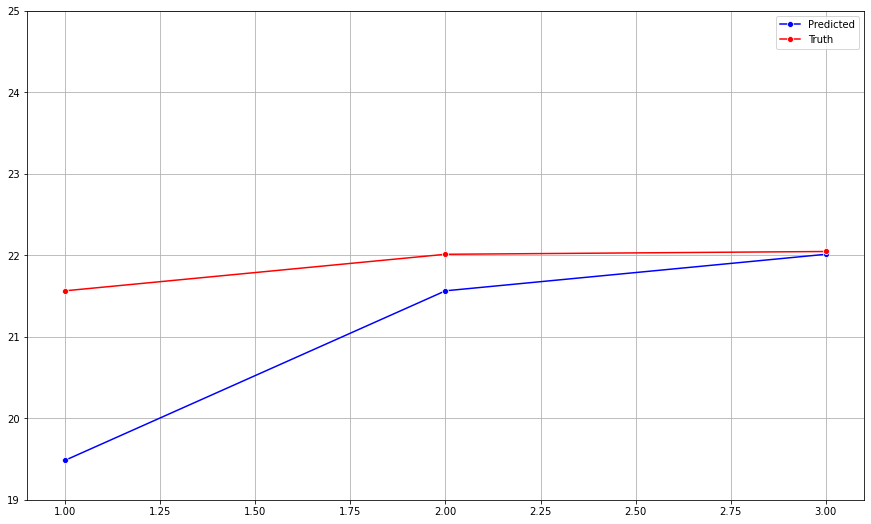

In [343]:
plt.figure(figsize = (15, 9))
plt.grid(True)
plt.ylim(ymin=19, ymax=25)

month_range = [1,2,3]

sns.lineplot(x=month_range, y=month_predictions, color = 'blue', marker = 'o', label = 'Predicted')
sns.lineplot(x=month_range, y=month_test, color = 'red', marker = 'o', label = 'Truth')

# Predicting weekly stock prices

In [344]:
import warnings
warnings.filterwarnings('ignore')
# ignore warnings for the following lines of code for week determination

In [345]:
# extract the weekly stock price averages for training and testing data
week_train = []
week_test = []

for i in range (1,54):
    week_train.append(df[(pd.DatetimeIndex(df['Date']).year == 2020) & (pd.DatetimeIndex(df['Date']).week == i)]['Price'].mean())
    week_test.append(df[(pd.DatetimeIndex(df['Date']).year == 2021) & (pd.DatetimeIndex(df['Date']).week == i)]['Price'].mean())
    
#remove null values from the list if a week is missing (especially true for weeks in an incomplete year, e.g. 2021)
week_train = [x for x in week_train if str(x) !='nan']
week_test = [x for x in week_test if str(x) != 'nan']

In [348]:
# run an ARIMA model for preciting average weekly stock price
week_predictions = []
week_test_obser = len(week_test)

for i in range(week_test_obser):
    model_week = ARIMA(week_train, order = (0, 1, 0)) # where p = 10 which is the number of lag observations, 
                                              #  d = 1 which is the number of times the raw observations are differenced to make the tren stationary
                                              # q = 0 which is the size of the moving average window
    model_week_fit =  model_week.fit()
    output_week = model_week_fit.forecast()
    
    week_predictions.append (output_week[0]) # append the predicted value to the model_predictions list
    
    week_test_value = week_test[i] # the corresponding test value of the month_test list
    week_train.append(week_test_value) # update the training dataset by appending the true_test_value. 
                                    # This will be used in the next training round

In [349]:
print(model_week_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   78
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -106.576
Date:                Mon, 08 Aug 2022   AIC                            215.153
Time:                        15:52:51   BIC                            217.496
Sample:                             0   HQIC                           216.090
                                 - 78                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9327      0.094      9.891      0.000       0.748       1.118
Ljung-Box (L1) (Q):                   2.88   Jarque-Bera (JB):                41.94
Prob(Q):                              0.09   Pr

<AxesSubplot:>

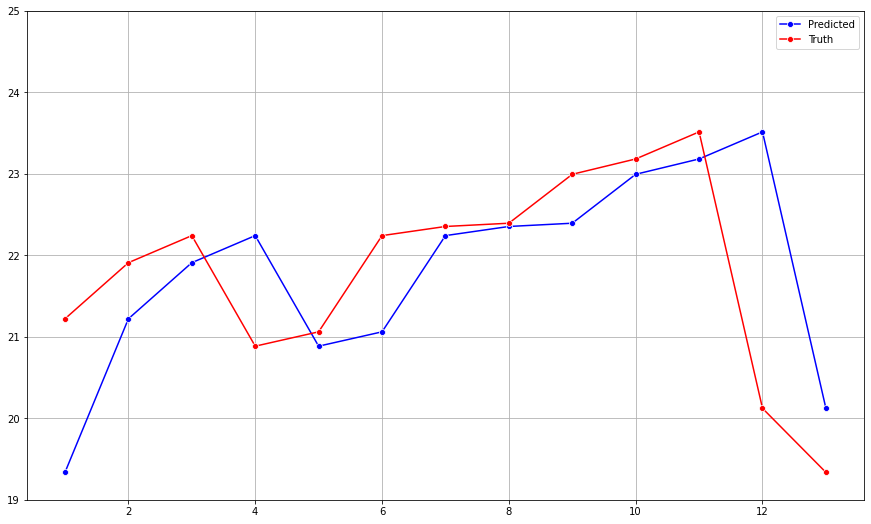

In [350]:
plt.figure(figsize = (15, 9))
plt.grid(True)
plt.ylim(ymin=19, ymax=25)

week_range = [1,2,3,4,5,6,7,8,9,10,11,12,13]

sns.lineplot(x=week_range, y=week_predictions, color = 'blue', marker = 'o', label = 'Predicted')
sns.lineplot(x=week_range, y=week_test, color = 'red', marker = 'o', label = 'Truth')